<a href="https://colab.research.google.com/github/takzen/pytorch-black-belt/blob/main/notebooks/47_Adversarial_Example_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --------------------------------------------------------------
# ☁️ COLAB SETUP (Automatyczna instalacja środowiska)
# --------------------------------------------------------------
import sys
import os

# Sprawdzamy, czy jesteśmy w Google Colab
if 'google.colab' in sys.modules:
    print('☁️ Wykryto środowisko Google Colab. Konfiguruję...')

    # 1. Pobieramy plik requirements.txt bezpośrednio z repozytorium
    !wget -q https://raw.githubusercontent.com/takzen/ai-engineering-handbook/main/requirements.txt -O requirements.txt

    # 2. Instalujemy biblioteki
    print('⏳ Instaluję zależności (to może chwilę potrwać)...')
    !pip install -q -r requirements.txt

    print('✅ Gotowe! Środowisko jest zgodne z repozytorium.')
else:
    print('💻 Wykryto środowisko lokalne. Zakładam, że masz już uv/venv.')


# 🥋 Lekcja 47: Adversarial Attacks (Hakowanie gradientem)

W standardowym treningu:
1.  Mamy stałe dane $X$.
2.  Zmieniamy wagi $W$, żeby zminimalizować błąd (Loss).
    $$ W_{new} = W - \alpha \cdot \nabla_W Loss $$

W ataku adwersarzowym (White Box):
1.  Mamy stałe wagi $W$ (zamrożony model).
2.  Zmieniamy dane $X$, żeby **ZMĄKSYMALIZOWAĆ** błąd.
    $$ X_{hack} = X + \epsilon \cdot \text{sign}(\nabla_X Loss) $$

**Klucz techniczny:**
Musimy ustawić `input_tensor.requires_grad = True`.
Dzięki temu PyTorch policzy pochodną błędu względem pikseli obrazka.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

# Konfiguracja
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPSILON = 0.05  # Siła ataku (im większa, tym bardziej widoczny szum)

# 1. Ładujemy model (ResNet18)
model = models.resnet18(weights='IMAGENET1K_V1').to(DEVICE)
model.eval() # Ważne: wyłączamy Dropout i Batch Norm

print(f"Model gotowy na: {DEVICE}")

Model gotowy na: cuda


## Przygotowanie "Ofiary"

Pobierzemy zdjęcie (np. Pandy lub Psa).
Kluczowe jest to, że musimy je znormalizować (bo tego wymaga ResNet), ale musimy też umieć tę normalizację cofnąć, żeby wyświetlić wynik.

In [2]:
# Pobieranie zdjęcia
url = "https://upload.wikimedia.org/wikipedia/commons/9/93/Golden_Retriever_Carlos_%2810581910556%29.jpg"
headers = {"User-Agent": "Mozilla/5.0"}

try:
    response = requests.get(url, headers=headers, timeout=5)
    img_pil = Image.open(BytesIO(response.content))
except:
    # Fallback na lokalny plik lub inny URL w razie problemów z siecią
    print("Błąd pobierania. Używam losowego szumu jako placeholder (to tylko demo).")
    img_pil = Image.fromarray(np.uint8(np.random.rand(224,224,3) * 255))

# Preprocessing
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Normalizacja (Standard ImageNet)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Przygotowanie tensora
# 1. Zamiana na tensor
img_tensor = preprocess(img_pil).unsqueeze(0).to(DEVICE)

# 2. KLUCZOWY MOMENT: Włączamy śledzenie gradientów dla OBRAZKA
img_tensor.requires_grad = True

# 3. Normalizacja (dopiero po requires_grad, żeby to było w grafie)
input_tensor = normalize(img_tensor)

print("Obrazek przygotowany. PyTorch śledzi każdy piksel.")

Obrazek przygotowany. PyTorch śledzi każdy piksel.


## Atak FGSM (Fast Gradient Sign Method)

1.  Przepuszczamy obrazek przez model.
2.  Liczymy `CrossEntropyLoss` względem poprawnej klasy (Pies).
3.  Robimy `backward()`.
4.  Zamiast aktualizować wagi modelu (które są zamrożone), pobieramy `img_tensor.grad`.
5.  Dodajemy do obrazka `epsilon * sign(gradient)`.

Funkcja `sign()` (znak) jest ważna – zmienia gradient na same -1 i +1. To maksymalizuje zniszczenie przy minimalnej zmianie wartości piksela.

In [3]:
# 1. Forward Pass
output = model(input_tensor)
init_pred = output.max(1, keepdim=True)[1] # Pobieramy indeks klasy

print(f"Oryginalna klasa: {init_pred.item()}")

# 2. Obliczamy stratę
loss = F.cross_entropy(output, init_pred[0])

# 3. Backward Pass (Liczymy gradienty względem PIKSELI)
model.zero_grad()
loss.backward()

# 4. Pobieramy gradient danych wejściowych
# data_grad to mapa o wymiarach obrazka, mówiąca "jak zmienić ten piksel, żeby zwiększyć błąd"
data_grad = img_tensor.grad.data

# 5. Tworzymy zaburzenie (Perturbation)
# sign() zwraca -1, 0 lub 1
perturbation = EPSILON * data_grad.sign()

# 6. Aplikujemy atak
# Dodajemy szum do oryginalnego obrazka (przed normalizacją)
hacked_img = img_tensor + perturbation

# Zabezpieczenie (Clamping): Piksele muszą być [0, 1]
hacked_img = torch.clamp(hacked_img, 0, 1)

print("Atak wykonany.")

Oryginalna klasa: 212
Atak wykonany.


## Weryfikacja Skuteczności

Sprawdźmy, co teraz widzi model.
Musimy ponownie znormalizować zhakowany obrazek, bo ResNet oczekuje średniej 0 i std 1.

In [4]:
# Normalizujemy zhakowany obrazek
hacked_input = normalize(hacked_img)

# Forward na zaatakowanym obrazku
output_adv = model(hacked_input)
final_pred = output_adv.max(1, keepdim=True)[1]

# Pobieramy nazwy klas
labels_url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
labels = requests.get(labels_url).text.splitlines()

orig_name = labels[init_pred.item()]
adv_name = labels[final_pred.item()]

print(f"Przed atakiem: {orig_name}")
print(f"Po ataku:      {adv_name}")

if init_pred.item() != final_pred.item():
    print("🚨 SUKCES! Model został oszukany.")
else:
    print("Porażka. Zwiększ EPSILON.")

Przed atakiem: English setter
Po ataku:      Labrador retriever
🚨 SUKCES! Model został oszukany.


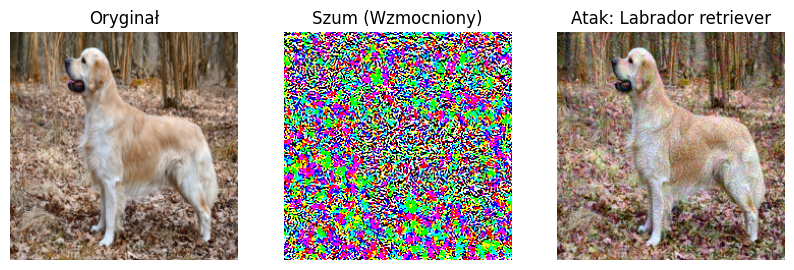

In [5]:
# WIZUALIZACJA
def show_tensor(tensor, title):
    # Odklejamy od GPU, usuwamy batch dim, zamieniamy (C,H,W) na (H,W,C)
    img = tensor.squeeze().detach().cpu().permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
show_tensor(img_tensor, "Oryginał")

plt.subplot(1, 3, 2)
# Wizualizacja szumu (skalowana, żeby było widać)
noise = perturbation.squeeze().detach().cpu().permute(1, 2, 0).numpy()
# Normalizujemy szum do 0-1 dla wyświetlenia
noise = (noise - noise.min()) / (noise.max() - noise.min())
plt.imshow(noise, cmap='gray')
plt.title("Szum (Wzmocniony)")
plt.axis('off')

plt.subplot(1, 3, 3)
show_tensor(hacked_img, f"Atak: {adv_name}")

plt.show()

## 🥋 Black Belt Summary

1.  **Dostęp do gradientów wejścia:** `tensor.requires_grad = True` na danych wejściowych pozwala traktować obrazek jak parametry modelu. Możemy go "trenować" (zmieniać), żeby osiągnąć dowolny cel (np. zmylić sieć).
2.  **Liniowość sieci:** FGSM działa tak dobrze, bo sieci neuronowe, mimo że "Deep", zachowują się bardzo liniowo. Mała zmiana wejścia w złym kierunku kumuluje się przez warstwy i powoduje dużą zmianę na wyjściu.
3.  **Obrona:** Jedyną skuteczną obroną jest **Adversarial Training** – wrzucanie takich zaszumionych przykładów do zbioru treningowego, żeby sieć nauczyła się je ignorować.